# Quantum computations application in Support Vector Machine for classification tasks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import (
    make_blobs, make_classification, load_wine, load_iris, load_digits, fetch_openml
)
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from qiskit import BasicAer, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC

In [2]:
random_state = 777
algorithm_globals.random_seed = random_state

## Dataset loaders

In [3]:
def tictactoe_loader():
    res = fetch_openml('tic-tac-toe')
    x, y = res.data, res.target
    for column in x.columns:
        x[column] = x[column].apply(lambda a: 1 if a == 'x' else -1 if a == 'o' else 0)
    y = y.apply(lambda a: 1 if a == 'positive' else 0)
    return x.values, y.values

def banknote_authentication_loader():
    res = fetch_openml('banknote-authentication')
    x, y = res.data, res.target.astype('int') - 1
    return x.values, y.values

def digits_loader():
    return load_digits(return_X_y=True)

def iris_loader():
    return load_iris(return_X_y=True)

def wine_loader():
    return load_wine(return_X_y=True)

def synth_clsf_loader(n_samples=500, n_features=4, n_classes=2):
    return make_classification(n_samples=n_samples, n_repeated=0, n_redundant=0,
                               n_features=n_features, n_informative=n_features,
                               n_classes=n_classes, random_state=random_state)

def synth_blobs_loader(n_samples=500, n_features=4, centers=2):
    return make_blobs(n_samples=n_samples, n_features=n_features,
                      centers=centers, random_state=random_state, center_box=(-3.0, 3.0))

In [4]:
clsf_datasets = {
    'Tic-Tac-Toe': tictactoe_loader(),
    'Banknote Authentication': banknote_authentication_loader(),
    'Digits': digits_loader(),
    'Iris': iris_loader(),
    'Wine': wine_loader(),
    'synth_bin_clsf': synth_clsf_loader(n_classes=2),
    'synth_multi_clsf': synth_clsf_loader(n_classes=5),
    'synth_blobs_2': synth_blobs_loader(centers=2),
    'synth_blobs_5': synth_blobs_loader(centers=5),
}

# process all datasets with 4 features (original or with dimension reduction)
n_features = 4
test_size = 0.25

/tmp/ipykernel_679129/3718948249.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[column] = x[column].apply(lambda a: 1 if a == 'x' else -1 if a == 'o' else 0)


In [5]:
datasets_info = pd.DataFrame({
    'Original features №': np.zeros(shape=(len(clsf_datasets),), dtype='int32'),
    'Classes': np.zeros(shape=(len(clsf_datasets),), dtype='int32'),
    'Samples': np.zeros(shape=(len(clsf_datasets),), dtype='int32')
}, index=list(clsf_datasets.keys()))
i = 0
for dataset_name, dataset in clsf_datasets.items():
    datasets_info['Original features №'][i] = dataset[0].shape[1]
    datasets_info['Classes'][i] = len(np.unique(dataset[1]))
    datasets_info['Samples'][i] = dataset[1].shape[0]
    i += 1

datasets_info

,Original features №,Classes,Samples
Tic-Tac-Toe,9,2,958
Banknote Authentication,4,2,1372
Digits,64,10,1797
Iris,4,3,150
Wine,13,3,178
synth_bin_clsf,4,2,500
synth_multi_clsf,4,5,500
synth_blobs_2,4,2,500
synth_blobs_5,4,5,500


## Classical kernels

In [6]:
kernels = {
    'Linear': 'linear',
    'RBF': 'rbf',
    'Polynomial': 'poly'
}

## Quantum kernels

In [7]:
# quantum kernels
backend = QuantumInstance(
    BasicAer.get_backend("statevector_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
    shots=1024 * 8
)

z_fm = ZFeatureMap(feature_dimension=n_features, reps=1)
z_kernel = QuantumKernel(feature_map=z_fm, quantum_instance=backend)

zz_fm = ZZFeatureMap(feature_dimension=n_features, reps=1)
zz_kernel = QuantumKernel(feature_map=zz_fm, quantum_instance=backend)

pauli_fm = PauliFeatureMap(feature_dimension=n_features, reps=1,
                           paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_fm, quantum_instance=backend)

Z Feature Map


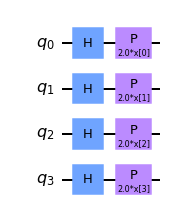

In [8]:
print('Z Feature Map')
z_fm.decompose().draw('mpl')

ZZ Feature Map


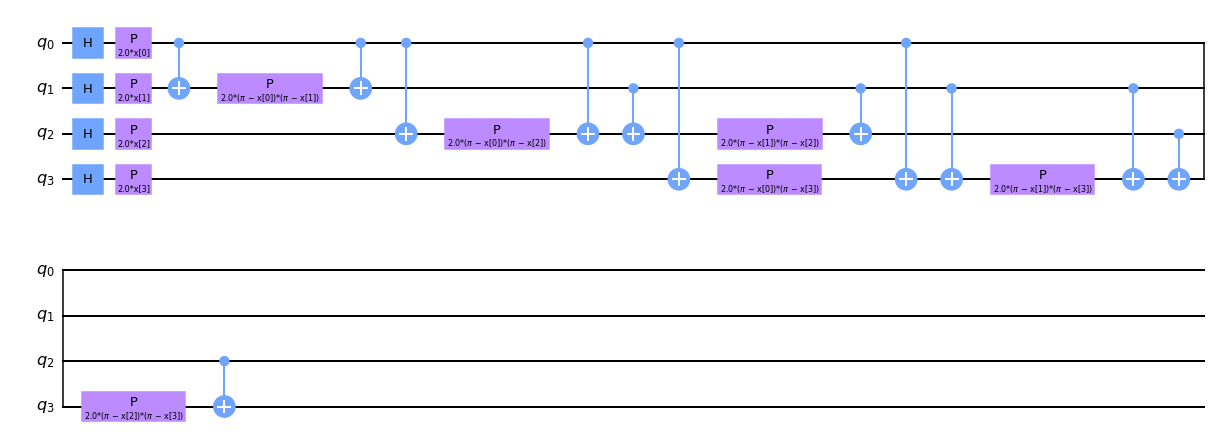

In [9]:
print('ZZ Feature Map')
zz_fm.decompose().draw('mpl')

Pauli Feature Map


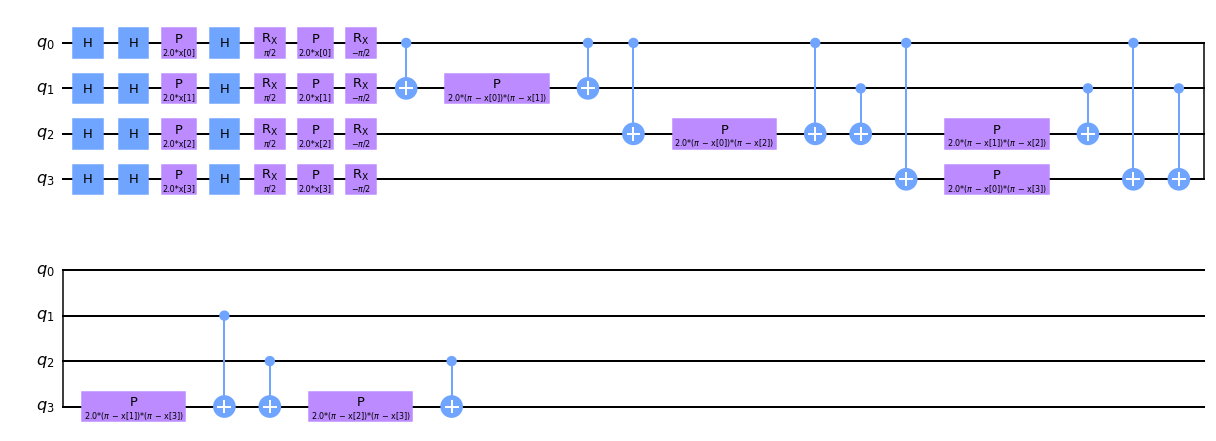

In [10]:
print('Pauli Feature Map')
pauli_fm.decompose().draw('mpl')

In [11]:
kernels.update({
    'Z': z_kernel.evaluate,
    'ZZ': zz_kernel.evaluate,
    'Pauli': pauli_kernel.evaluate
})

## Kernels evaluation on datasets

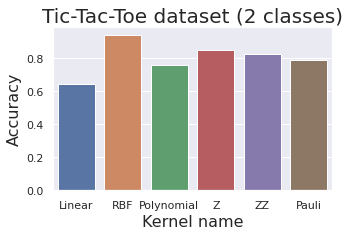

Training input shape: (718, 4)
Testing input shape: (240, 4)

Accuracy:
RBF           0.937500
Z             0.845833
ZZ            0.820833
Pauli         0.787500
Polynomial    0.758333
Linear        0.641667
dtype: float64


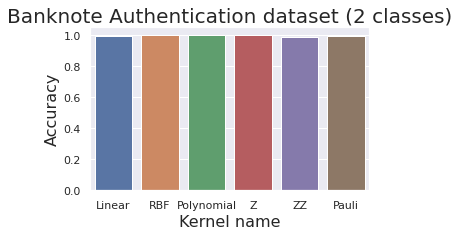

Training input shape: (1029, 4)
Testing input shape: (343, 4)

Accuracy:
RBF           1.000000
Polynomial    1.000000
Z             1.000000
Linear        0.994169
Pauli         0.994169
ZZ            0.988338
dtype: float64


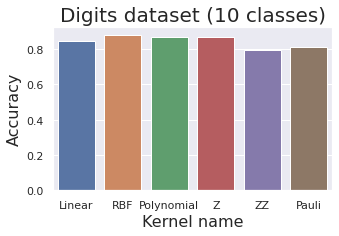

Training input shape: (1347, 4)
Testing input shape: (450, 4)

Accuracy:
RBF           0.880000
Z             0.868889
Polynomial    0.866667
Linear        0.846667
Pauli         0.811111
ZZ            0.795556
dtype: float64


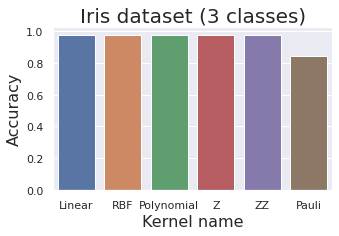

Training input shape: (112, 4)
Testing input shape: (38, 4)

Accuracy:
Linear        0.973684
RBF           0.973684
Polynomial    0.973684
Z             0.973684
ZZ            0.973684
Pauli         0.842105
dtype: float64


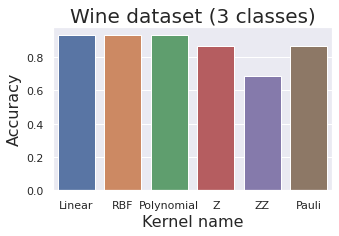

Training input shape: (133, 4)
Testing input shape: (45, 4)

Accuracy:
Linear        0.933333
RBF           0.933333
Polynomial    0.933333
Z             0.866667
Pauli         0.866667
ZZ            0.688889
dtype: float64


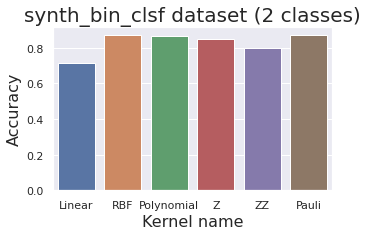

Training input shape: (375, 4)
Testing input shape: (125, 4)

Accuracy:
RBF           0.872
Pauli         0.872
Polynomial    0.864
Z             0.848
ZZ            0.800
Linear        0.712
dtype: float64


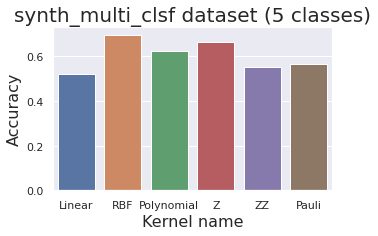

Training input shape: (375, 4)
Testing input shape: (125, 4)

Accuracy:
RBF           0.696
Z             0.664
Polynomial    0.624
Pauli         0.568
ZZ            0.552
Linear        0.520
dtype: float64


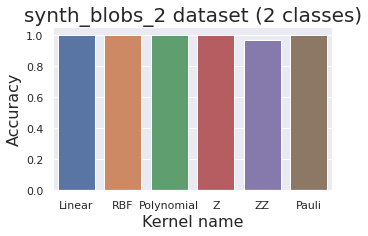

Training input shape: (375, 4)
Testing input shape: (125, 4)

Accuracy:
Linear        1.000
RBF           1.000
Polynomial    1.000
Z             1.000
Pauli         1.000
ZZ            0.968
dtype: float64


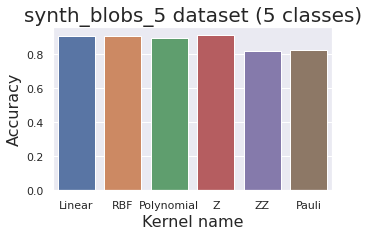

Training input shape: (375, 4)
Testing input shape: (125, 4)

Accuracy:
Z             0.912
Linear        0.904
RBF           0.904
Polynomial    0.896
Pauli         0.824
ZZ            0.816
dtype: float64


In [14]:
def preprocessing(x, y, n_features, test_size):
    if x.shape[1] > n_features:
        x = PCA(n_components=n_features).fit_transform(x)
    elif x.shape[1] < n_features:
        raise ValueError('X number of features is less than required')
    x = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(x)
    return train_test_split(x, y, test_size=test_size, random_state=random_state)


sb.set_theme()
for dataset_name, dataset in clsf_datasets.items():
    x_train, x_test, y_train, y_test = preprocessing(*dataset, n_features, test_size)
    kernel_metrics = []
    for kernel_name, kernel in kernels.items():
        svc = SVC(kernel=kernel, C=10.0)
        svc.fit(x_train, y_train)
        kernel_metrics.append(svc.score(x_test, y_test))
    kernel_metrics = pd.Series(kernel_metrics, index=list(kernels.keys()))
    plt.title(f'{dataset_name} dataset ({len(np.unique(y_train))} classes)', fontsize=20)
    plt.xlabel('Kernel name', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    sb.barplot(x=kernel_metrics.index, y=kernel_metrics)
    plt.show()
    print(f'Training input shape: {x_train.shape}')
    print(f'Testing input shape: {x_test.shape}\n')
    print('Accuracy:', kernel_metrics.sort_values(ascending=False), sep='\n')

## Experiments with operator repetitions

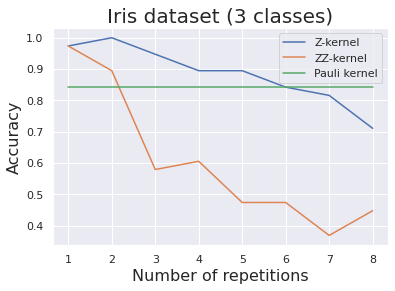

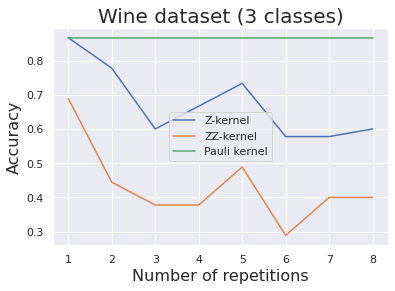

In [26]:
# maximum number of repetitions
n = 8

selected_clsf_datasets = {
    'Iris': iris_loader(),
    'Wine': wine_loader(),
}
for dataset_name, dataset in selected_clsf_datasets.items():
    x_train, x_test, y_train, y_test = preprocessing(*dataset, n_features, test_size)
    
    z_kernel_metrics = []
    zz_kernel_metrics = []
    pauli_kernel_metrics = []
    for i in range(1, n+1):
        z_repeated_fm = ZFeatureMap(feature_dimension=n_features, reps=i)
        z_repeated_kernel = QuantumKernel(feature_map=z_repeated_fm, quantum_instance=backend)
        svc = SVC(kernel=z_repeated_kernel.evaluate, C=10.0)
        svc.fit(x_train, y_train)
        z_kernel_metrics.append(svc.score(x_test, y_test))
        
        zz_repeated_fm = ZZFeatureMap(feature_dimension=n_features, reps=i)
        zz_repeated_kernel = QuantumKernel(feature_map=zz_repeated_fm, quantum_instance=backend)
        svc = SVC(kernel=zz_repeated_kernel.evaluate, C=10.0)
        svc.fit(x_train, y_train)
        zz_kernel_metrics.append(svc.score(x_test, y_test))
        
        pauli_repeated_fm = PauliFeatureMap(feature_dimension=n_features, reps=i,
                                            paulis = ['X', 'Y', 'ZZ'])
        pauli_repeated_kernel = QuantumKernel(feature_map=pauli_fm, quantum_instance=backend)
        svc = SVC(kernel=pauli_repeated_kernel.evaluate, C=10.0)
        svc.fit(x_train, y_train)
        pauli_kernel_metrics.append(svc.score(x_test, y_test))

    sb.lineplot(x=list(range(1, n+1)), y=z_kernel_metrics,
                markers=True, label='Z-kernel')
    sb.lineplot(x=list(range(1, n+1)), y=zz_kernel_metrics,
                markers=True, label='ZZ-kernel')
    sb.lineplot(x=list(range(1, n+1)), y=pauli_kernel_metrics,
                markers=True, label='Pauli kernel')
    plt.title(f'{dataset_name} dataset ({len(np.unique(y_train))} classes)', fontsize=20)
    plt.xlabel('Number of repetitions', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.show()